In [1]:
import sys
from pathlib import Path

# Notebook ka folder
NOTEBOOK_DIR = Path().resolve()

# Project root = parent folder
PROJECT_ROOT = NOTEBOOK_DIR.parent

# Add project root to import path
sys.path.append(str(PROJECT_ROOT))

print("Project root:", PROJECT_ROOT)


Project root: D:\Langchain_LangGraph_03-12-2025\MyProject


In [2]:
#now importing all the Module which is used to build the AI Model.
from langchain_core.prompts import PromptTemplate,ChatPromptTemplate
from exception import CustomException
from logger_config import logger
import os,sys

#using openai chat model and embedding models
from langchain_openai import ChatOpenAI,OpenAIEmbeddings

#using groq chat model 
from langchain_groq import ChatGroq

#using open source chat model from hugging Face
from langchain_huggingface import ChatHuggingFace,HuggingFaceEmbeddings,HuggingFaceEndpoint

from config import *

from langchain_core.runnables import RunnableBranch,RunnableLambda,RunnableParallel,RunnableSequence,RunnablePassthrough

[2025-12-07 22:46:39,375]-config_variable.py-INFO -Loading the environment Variable
[2025-12-07 22:46:39,380]-config_variable.py-INFO -Environment Variable successfully Loaded


In [3]:
%pwd

'd:\\Langchain_LangGraph_03-12-2025\\MyProject\\notebooks'

In [4]:
#import Langgraph related Modules
import langgraph
from langgraph.graph import StateGraph,START,END
from dataclasses import dataclass
from typing import TypedDict
from typing import Literal,List,Annotated
from langchain_core.messages import AnyMessage,AIMessage,HumanMessage,ToolMessage

from pydantic import BaseModel,Field #using this class we can perform validation to schema

from langgraph.prebuilt import tool_node,tools_condition #in this class we put all tools together
#tools_condition wrt to tool msg it will route the flow data to ttol node to perform execution

from langchain_core.tools import tool,Tool,StructuredTool

from langgraph.graph.message import BaseMessage #this is special class which hold every mesaage init.

from langchain_core.output_parsers import StrOutputParser,PydanticOutputParser


parser = StrOutputParser()

from langgraph.checkpoint.memory import InMemorySaver #this will save the converstion history in ram memory
from langchain_core.runnables import RunnableConfig   #this will help to induce the thread_id or user identification in converstion

## step:1) defining the models components

In [5]:
model1 = ChatOpenAI(
    model="gpt-3.5-turbo",
    temperature=0.2 #we call as creative parameter
)
model1

ChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x000001E82B5B9EA0>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x000001E82BC1DFF0>, root_client=<openai.OpenAI object at 0x000001E82B5BA320>, root_async_client=<openai.AsyncOpenAI object at 0x000001E82B5B9FF0>, temperature=0.2, model_kwargs={}, openai_api_key=SecretStr('**********'))

In [6]:
model2 = ChatGroq(
    model="llama-3.1-8b-instant",
    temperature=0.2 #we call as creative parameter
)
model2

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000001E82BD17010>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001E82BD51AB0>, model_name='llama-3.1-8b-instant', temperature=0.2, model_kwargs={}, groq_api_key=SecretStr('**********'))

In [7]:
llm = HuggingFaceEndpoint(  
repo_id="meta-llama/Llama-3.1-8B-Instruct",  
task="text-generation",  
max_new_tokens=512,  
do_sample=False,  
repetition_penalty=1.03,  
)  

model3 = ChatHuggingFace(llm=llm, verbose=True)
model3

ChatHuggingFace(llm=HuggingFaceEndpoint(repo_id='meta-llama/Llama-3.1-8B-Instruct', repetition_penalty=1.03, stop_sequences=[], server_kwargs={}, model_kwargs={}, model='meta-llama/Llama-3.1-8B-Instruct', client=<InferenceClient(model='meta-llama/Llama-3.1-8B-Instruct', timeout=120)>, async_client=<InferenceClient(model='meta-llama/Llama-3.1-8B-Instruct', timeout=120)>, task='text-generation'), model_id='meta-llama/Llama-3.1-8B-Instruct', model_kwargs={})

## building different type of complex workflows using LangGraph

### 1) building Persistence Memory workflow

#### defining state or memory schema for this workflow

In [8]:
class JokeExplainerSchema(TypedDict):
    topic : str
    joke_generate  : str | None
    joke_explainer : str | None
    

In [9]:
#now creating an object of stategraph class futhure this will be used to build theworkflow.
graph = StateGraph(state_schema=JokeExplainerSchema)

In [10]:
#want to save the converstion each user in Mmemory that why we ar eusing InMemorySaver class
memory = InMemorySaver()
memory

In [11]:
#now defining the node for my workflow..node will execute the task 
def JokeGenerationNode(state:JokeExplainerSchema)->JokeExplainerSchema:
    #now fetching the topic from state.
    topic = state['topic']
    
    #dynamic user prompt converting into structure instruction prompt.
    prompt = PromptTemplate(
        template="""
        You are a professional comedy writer.

        Task:
        - Generate ONE short joke based on the given topic.
        - The joke must be 1–2 lines only.
        - Make it witty, hilarious, and straight to the point.
        - Avoid explanations, emojis, or extra text.

        Topic: {topic}

        Output:
        The joke only.
        
        """,
        input_variables=['topic']
    )
    
    #forming the chain to execute the task sequentially.
    chain = prompt | model2 | parser
    
    #invoking the chain to perform execution.
    response = chain.invoke(input={'topic':topic})
    
    return {
        'joke_generate':response
    }

In [12]:
def JokeExplainerNode(state:JokeExplainerSchema)->JokeExplainerSchema:
    #now fetching the topic from state.
    topic = state['topic']
    joke = state['joke_generate']
    
    #dynamic user prompt converting into structure instruction prompt.
    prompt = PromptTemplate(
        template="""
        You are an expert humor analyst.

        Task:
        - Explain the meaning of the given joke.
        - Keep the explanation clear, simple, and easy to understand.
        - Limit the explanation to 1–2 short lines.
        - Do NOT rewrite the joke.
        - Do NOT add jokes, emojis, or extra commentary.

        Joke:
        {joke}

        Output:
        Only the explanation.
                
        """,
        input_variables=['joke']
    )
    #forming the chain to execute the task sequentially.
    chain = prompt | model3 | parser
    
    #invoking the chain to perform execution.
    response = chain.invoke(input={'joke':joke})
    
    return {
        'joke_explainer':response
    }
    

In [13]:
#now adding the edges or node to the graph.
graph.add_node(node="JokeGenerationNode",action=JokeGenerationNode)
graph.add_node(node="JokeExplainerNode",action=JokeExplainerNode)
graph.add_edge(start_key=START,end_key="JokeGenerationNode")
graph.add_edge(start_key='JokeGenerationNode',end_key="JokeExplainerNode")
graph.add_edge("JokeExplainerNode",END)

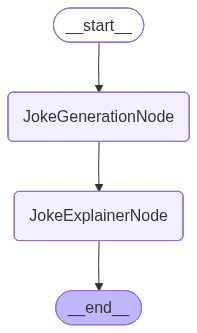

In [14]:
#defining the workflow.
workflow = graph.compile(checkpointer=memory)
workflow

In [15]:
run_config: RunnableConfig = {"configurable": {"thread_id": "1"}}
run_config

{'configurable': {'thread_id': '1'}}

In [16]:
#now initiating the JokeExplainerSchema.
state = JokeExplainerSchema(topic="AI")

#now invoking the workflow.
result = workflow.invoke(input=state,config=run_config)
result


[2025-12-07 22:46:41,622]-_client.py-INFO -HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


{'topic': 'AI',
 'joke_generate': 'I told my AI assistant to write a joke, but it just kept generating the same one.',
 'joke_explainer': 'The joke is about the frustration and irony of relying on an AI to create something creative, but it ends up being unoriginal and repetitive. The humor comes from the self-aware absurdity of using AI to create humor that fails to be humorous.'}

### get the latest state(memory) or final state snapshot

In [17]:
workflow.get_state(run_config)

StateSnapshot(values={'topic': 'AI', 'joke_generate': 'I told my AI assistant to write a joke, but it just kept generating the same one.', 'joke_explainer': 'The joke is about the frustration and irony of relying on an AI to create something creative, but it ends up being unoriginal and repetitive. The humor comes from the self-aware absurdity of using AI to create humor that fails to be humorous.'}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0d3908-074d-6d5f-8002-28399a405a2b'}}, metadata={'source': 'loop', 'step': 2, 'parents': {}}, created_at='2025-12-07T17:16:43.237923+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0d3907-f829-68d7-8001-6dc4301f7fb0'}}, tasks=(), interrupts=())

## Get all state history for paticular thread_id

In [18]:
list(workflow.get_state_history(run_config)) #between the 2 nodes conversation we are getting through get_state() method

[StateSnapshot(values={'topic': 'AI', 'joke_generate': 'I told my AI assistant to write a joke, but it just kept generating the same one.', 'joke_explainer': 'The joke is about the frustration and irony of relying on an AI to create something creative, but it ends up being unoriginal and repetitive. The humor comes from the self-aware absurdity of using AI to create humor that fails to be humorous.'}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0d3908-074d-6d5f-8002-28399a405a2b'}}, metadata={'source': 'loop', 'step': 2, 'parents': {}}, created_at='2025-12-07T17:16:43.237923+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0d3907-f829-68d7-8001-6dc4301f7fb0'}}, tasks=(), interrupts=()),
 StateSnapshot(values={'topic': 'AI', 'joke_generate': 'I told my AI assistant to write a joke, but it just kept generating the same one.'}, next=('JokeExplainerNode',), config={'configurable': {'thread_id

### agar mujhe koi paticular checkpointer_id pe jana to see that point state value woh bhi achieve hoga

In [19]:
config={'configurable': {'thread_id': '1', 'checkpoint_id': '1f0d38ad-790a-68f4-8000-8e4c4f91c9d9'}}
workflow.get_state(config)

StateSnapshot(values={}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_id': '1f0d38ad-790a-68f4-8000-8e4c4f91c9d9'}}, metadata=None, created_at=None, parent_config=None, tasks=(), interrupts=())

In [20]:
run_config2: RunnableConfig = {"configurable": {"thread_id": "2"}}
run_config2

{'configurable': {'thread_id': '2'}}

In [21]:
#now initiating the JokeExplainerSchema.
state = JokeExplainerSchema(topic="pasta")

#now invoking the workflow.
result = workflow.invoke(input=state,config=run_config2)
result


[2025-12-07 22:46:43,438]-_client.py-INFO -HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


{'topic': 'pasta',
 'joke_generate': "I'm not lazy, I'm just on pasta time – it's a carb-load thing.",
 'joke_explainer': "This joke is about procrastination, comparing the speaker's lack of motivation to needing time to digest a carb-heavy meal, like pasta."}

In [22]:
list(workflow.get_state_history(run_config2))

[StateSnapshot(values={'topic': 'pasta', 'joke_generate': "I'm not lazy, I'm just on pasta time – it's a carb-load thing.", 'joke_explainer': "This joke is about procrastination, comparing the speaker's lack of motivation to needing time to digest a carb-heavy meal, like pasta."}, next=(), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f0d3908-1501-6551-8002-1ec18628b5a0'}}, metadata={'source': 'loop', 'step': 2, 'parents': {}}, created_at='2025-12-07T17:16:44.674593+00:00', parent_config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f0d3908-0944-67d6-8001-c72d0585ac1a'}}, tasks=(), interrupts=()),
 StateSnapshot(values={'topic': 'pasta', 'joke_generate': "I'm not lazy, I'm just on pasta time – it's a carb-load thing."}, next=('JokeExplainerNode',), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f0d3908-0944-67d6-8001-c72d0585ac1a'}}, metadata={'source': 'loop', 'step': 1, 'parents': {

## at any point pe we can update the state and value too like given below

### Time Travel :- kind of benefit

### at paticular point we are going re executing task again

In [24]:
config2={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f0d3908-080d-6a85-8000-0893348c8d60'}}
#resume again from this point
workflow.invoke(input=None,config=config2)

[2025-12-07 22:47:39,478]-_client.py-INFO -HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


{'topic': 'pasta',
 'joke_generate': "I'm not lazy, I'm just on pasta time – it takes a while to wind up.",
 'joke_explainer': 'The joke compares the concept of "winding up" (getting ready to do something) to the slow cooking time of pasta, implying that the speaker takes a long time to get started.'}

In [25]:
list(workflow.get_state_history(run_config2))

[StateSnapshot(values={'topic': 'pasta', 'joke_generate': "I'm not lazy, I'm just on pasta time – it takes a while to wind up.", 'joke_explainer': 'The joke compares the concept of "winding up" (getting ready to do something) to the slow cooking time of pasta, implying that the speaker takes a long time to get started.'}, next=(), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f0d390a-3105-669c-8002-17399593e6aa'}}, metadata={'source': 'loop', 'step': 2, 'parents': {}}, created_at='2025-12-07T17:17:41.298364+00:00', parent_config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f0d390a-1fba-6d82-8001-077ca1ffe7a6'}}, tasks=(), interrupts=()),
 StateSnapshot(values={'topic': 'pasta', 'joke_generate': "I'm not lazy, I'm just on pasta time – it takes a while to wind up."}, next=('JokeExplainerNode',), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f0d390a-1fba-6d82-8001-077ca1ffe7a6'}}, meta

## want to update state

In [26]:
config2={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f0d3908-080d-6a85-8000-0893348c8d60'}}
workflow.update_state(config=config2,values={"topic":"samosa"})

{'configurable': {'thread_id': '2',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0d390d-9286-6c87-8001-bc9232e3b842'}}

In [27]:
list(workflow.get_state_history(run_config2))

[StateSnapshot(values={'topic': 'samosa'}, next=('JokeGenerationNode',), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f0d390d-9286-6c87-8001-bc9232e3b842'}}, metadata={'source': 'update', 'step': 1, 'parents': {}}, created_at='2025-12-07T17:19:12.054183+00:00', parent_config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f0d3908-080d-6a85-8000-0893348c8d60'}}, tasks=(PregelTask(id='dccf8edb-2847-78d4-f7a4-c94ea9b10279', name='JokeGenerationNode', path=('__pregel_pull', 'JokeGenerationNode'), error=None, interrupts=(), state=None, result=None),), interrupts=()),
 StateSnapshot(values={'topic': 'pasta', 'joke_generate': "I'm not lazy, I'm just on pasta time – it takes a while to wind up.", 'joke_explainer': 'The joke compares the concept of "winding up" (getting ready to do something) to the slow cooking time of pasta, implying that the speaker takes a long time to get started.'}, next=(), config={'configurable': {'thread

In [28]:
workflow.invoke(input=None,config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f0d390d-9286-6c87-8001-bc9232e3b842'}})

[2025-12-07 22:49:53,094]-_client.py-INFO -HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


{'topic': 'samosa',
 'joke_generate': "I filled my samosa with regret, now I'm crumby.",
 'joke_explainer': 'The joke is about a person who filled their food with emotional regret, resulting in a disappointing or failing outcome, which is a play on words with the samosa becoming crumbly. The punchline is a wordplay on the phrases "crumby" (bad) and "crumbly" (a texture).'}

In [29]:
list(workflow.get_state_history(run_config2))

[StateSnapshot(values={'topic': 'samosa', 'joke_generate': "I filled my samosa with regret, now I'm crumby.", 'joke_explainer': 'The joke is about a person who filled their food with emotional regret, resulting in a disappointing or failing outcome, which is a play on words with the samosa becoming crumbly. The punchline is a wordplay on the phrases "crumby" (bad) and "crumbly" (a texture).'}, next=(), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f0d390f-2a43-61bf-8003-e153c1046e8e'}}, metadata={'source': 'loop', 'step': 3, 'parents': {}}, created_at='2025-12-07T17:19:54.808364+00:00', parent_config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f0d390f-1a47-6b8b-8002-ee70071c7e8e'}}, tasks=(), interrupts=()),
 StateSnapshot(values={'topic': 'samosa', 'joke_generate': "I filled my samosa with regret, now I'm crumby."}, next=('JokeExplainerNode',), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoi

### if any time fault tolerance occur we can resume the workflow by passing None to it
### workflow.invoke(None, config=config)